# Collaboration and Competition

---

You are welcome to use this coding environment to train your agent for the project.  Follow the instructions below to get started!

### 1. Start the Environment

Run the next code cell to install a few packages.  This line will take a few minutes to run!

In [1]:
!pip -q install ./python

tensorflow 1.7.1 has requirement numpy>=1.13.3, but you'll have numpy 1.12.1 which is incompatible.
ipython 6.5.0 has requirement prompt-toolkit<2.0.0,>=1.0.15, but you'll have prompt-toolkit 3.0.5 which is incompatible.


The environment is already saved in the Workspace and can be accessed at the file path provided below. 

In [2]:
from unityagents import UnityEnvironment
import numpy as np

env = UnityEnvironment(file_name="/data/Tennis_Linux_NoVis/Tennis")

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: TennisBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 8
        Number of stacked Vector Observation: 3
        Vector Action space type: continuous
        Vector Action space size (per agent): 2
        Vector Action descriptions: , 


Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [3]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

### 2. Examine the State and Action Spaces

Run the code cell below to print some information about the environment.

In [4]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents 
num_agents = len(env_info.agents)
print('Number of agents:', num_agents)

# size of each action
action_size = brain.vector_action_space_size
print('Size of each action:', action_size)

# examine the state space 
states = env_info.vector_observations
print(states.shape)
state_size = states.shape[1]
print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))
print('The state for the first agent looks like:', states[0])

Number of agents: 2
Size of each action: 2
(2, 24)
There are 2 agents. Each observes a state with length: 24
The state for the first agent looks like: [ 0.          0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.          0.
  0.          0.         -6.65278625 -1.5        -0.          0.
  6.83172083  6.         -0.          0.        ]


### 3. Take Random Actions in the Environment

In the next code cell, you will learn how to use the Python API to control the agent and receive feedback from the environment.

Note that **in this coding environment, you will not be able to watch the agents while they are training**, and you should set `train_mode=True` to restart the environment.

In [5]:
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F

def hidden_init(layer):
    fan_in = layer.weight.data.size()[0]
    lim = 1. / np.sqrt(fan_in)
    return (-lim, lim)

class Actor(nn.Module):
    """Actor (Policy) Model."""

    def __init__(self, state_size, action_size, seed=0, fc1_units=256, fc2_units=128):
        
        super(Actor, self).__init__()
        self.seed = torch.manual_seed(seed)
        self.fc1 = nn.Linear(state_size, fc1_units)
        self.fc2 = nn.Linear(fc1_units, fc2_units)
        self.fc3 = nn.Linear(fc2_units, action_size)
        self.bn1 = nn.BatchNorm1d(fc1_units)
        self.reset_parameters()

    def reset_parameters(self):
        self.fc1.weight.data.uniform_(*hidden_init(self.fc1))
        self.fc2.weight.data.uniform_(*hidden_init(self.fc2))
        self.fc3.weight.data.uniform_(-3e-3, 3e-3)

    def forward(self, state):
        if state.dim() == 1:
            state = torch.unsqueeze(state,0)
        x = F.relu(self.fc1(state))
        x = self.bn1(x)
        x = F.relu(self.fc2(x))
        return torch.tanh(self.fc3(x))

class Critic(nn.Module):

    def __init__(self, full_state_size, actions_size, seed=0, fcs1_units=256, fc2_units=128):
        
        super(Critic, self).__init__()
        self.seed = torch.manual_seed(seed)
        self.fcs1 = nn.Linear(full_state_size, fcs1_units)
        self.fc2 = nn.Linear(fcs1_units+actions_size, fc2_units)
        self.fc3 = nn.Linear(fc2_units, 1)
        self.bn1 = nn.BatchNorm1d(fcs1_units)
        self.reset_parameters()

    def reset_parameters(self):
        self.fcs1.weight.data.uniform_(*hidden_init(self.fcs1))
        self.fc2.weight.data.uniform_(*hidden_init(self.fc2))
        self.fc3.weight.data.uniform_(-3e-3, 3e-3)

    def forward(self, state, action):
        xs = F.relu(self.fcs1(state))
        xs = self.bn1(xs)
        x = torch.cat((xs, action), dim=1)
        x = F.relu(self.fc2(x))
        return self.fc3(x)

When finished, you can close the environment.

### 4. It's Your Turn!

Now it's your turn to train your own agent to solve the environment!  A few **important notes**:
- When training the environment, set `train_mode=True`, so that the line for resetting the environment looks like the following:
```python
env_info = env.reset(train_mode=True)[brain_name]
```
- To structure your work, you're welcome to work directly in this Jupyter notebook, or you might like to start over with a new file!  You can see the list of files in the workspace by clicking on **_Jupyter_** in the top left corner of the notebook.
- In this coding environment, you will not be able to watch the agents while they are training.  However, **_after training the agents_**, you can download the saved model weights to watch the agents on your own machine! 

In [6]:
import numpy as np
import random
import copy
from collections import namedtuple, deque


import torch
import torch.nn.functional as F
import torch.optim as optim

#
x
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

class Agent():
    
    def __init__(self, state_size, action_size, num_agents, random_seed):
        
        self.state_size = state_size
        self.action_size = action_size
        self.seed = random.seed(random_seed)

        # Actor Network (w/ Target Network)
        self.actor_local = Actor(state_size, action_size, random_seed).to(device)
        self.actor_target = Actor(state_size, action_size, random_seed).to(device)
        self.actor_optimizer = optim.Adam(self.actor_local.parameters(), lr=LR_ACTOR)

        # Critic Network (w/ Target Network)
        self.critic_local = Critic(state_size*num_agents, action_size*num_agents, random_seed).to(device)
        self.critic_target = Critic(state_size*num_agents, action_size*num_agents, random_seed).to(device)
        self.critic_optimizer = optim.Adam(self.critic_local.parameters(), lr=LR_CRITIC, weight_decay=WEIGHT_DECAY)

        self.soft_update(self.critic_local, self.critic_target, 1)
        self.soft_update(self.actor_local, self.actor_target, 1)    
        
        # Noise process
        self.noise = OUNoise(action_size, random_seed)
        self.noise_reduction_ratio = NOISE_START

        self.step_count = 0

    def act(self, state, i_episode, add_noise=True):
        """Returns actions for given state as per current policy."""
        state = torch.from_numpy(state).float().to(device)
        self.actor_local.eval()
        with torch.no_grad():
            action = self.actor_local(state).cpu().data.numpy()
        self.actor_local.train()
        
        if add_noise:
            if i_episode > EPISODES_BEFORE_TRAINING and self.noise_reduction_ratio > NOISE_END:
                self.noise_reduction_ratio = NOISE_REDUCTION_RATE**(i_episode-EPISODES_BEFORE_TRAINING)
#             noise_reduction_ratio = 1
            action += self.noise_reduction_ratio * self.add_noise2()
#             action += noise_reduction_ratio * self.noise.sample()
        return np.clip(action, -1, 1)

    def add_noise2(self):
#         noise = 0.5*np.random.randn(1,self.action_size) #sigma of 0.5 as sigma of 1 will have alot of actions just clipped
        noise = 0.5*np.random.standard_normal(self.action_size)
        return noise
    
    def reset(self):
        self.noise.reset()

    def learn(self, experiences, gamma):
        
        full_states, actions, actor_local_actions, actor_target_actions, agent_state, agent_action, agent_reward, agent_done, next_states, next_full_states = experiences
        Q_targets_next = self.critic_target(next_full_states, actor_target_actions)
        # Compute Q targets for current states (y_i)
        Q_targets = agent_reward + (gamma * Q_targets_next * (1 - agent_done))
        # Compute critic loss
        Q_expected = self.critic_local(full_states, actions)
        critic_loss = F.mse_loss(Q_expected, Q_targets)
        # Minimize the loss
        self.critic_optimizer.zero_grad()
        critic_loss.backward()
        self.critic_optimizer.step()

        # ---------------------------- update actor ---------------------------- #
        # Compute actor loss
#         actions_pred = self.actor_local(agent_state)
        actor_loss = -self.critic_local(full_states, actor_local_actions).mean()
        # Minimize the loss
        self.actor_optimizer.zero_grad()
        actor_loss.backward()
        self.actor_optimizer.step()

    def hard_copy_weights(self, target, source):
        """ copy weights from source to target network (part of initialization)"""
        for target_param, param in zip(target.parameters(), source.parameters()):
            target_param.data.copy_(param.data)
            
    def soft_update(self, local_model, target_model, tau):
        """Soft update model parameters.
        θ_target = τ*θ_local + (1 - τ)*θ_target
        Params
        ======
            local_model: PyTorch model (weights will be copied from)
            target_model: PyTorch model (weights will be copied to)
            tau (float): interpolation parameter 
        """
        for target_param, local_param in zip(target_model.parameters(), local_model.parameters()):
            target_param.data.copy_(tau*local_param.data + (1.0-tau)*target_param.data)

class OUNoise:
    """Ornstein-Uhlenbeck process."""

    def __init__(self, size, seed, mu=0., theta=0.15, sigma=0.1):
        """Initialize parameters and noise process."""
        self.mu = mu * np.ones(size)
        self.theta = theta
        self.sigma = sigma
        self.seed = random.seed(seed)
        self.reset()
        self.size = size

    def reset(self):
        """Reset the internal state (= noise) to mean (mu)."""
        self.state = copy.copy(self.mu)

    def sample(self):
        """Update internal state and return it as a noise sample."""
        x = self.state
#         dx = self.theta * (self.mu - x) + self.sigma * np.array([random.random() for i in range(len(x))])
        dx = self.theta * (self.mu - x) + self.sigma * np.random.standard_normal(self.size)
        self.state = x + dx
        return self.state

In [7]:
import torch

import random
from collections import namedtuple, deque
import numpy as np


BUFFER_SIZE = int(1e6)  # replay buffer size
BATCH_SIZE = 256        # minibatch size
UPDATE_FREQ = 1

GAMMA = 0.99            # discount factor
TAU = 1e-3              # for soft update of target parameters

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

class MADDPG():
    
    def __init__(self, state_size, action_size, num_agents, random_seed):
        
        self.state_size = state_size
        self.action_size = action_size
        self.random_seed = random.seed(random_seed)
        
        # creating agents and store them into agents list
        self.agents = [Agent(state_size, action_size, num_agents, random_seed) for i in range(num_agents)]
        
        # Replay memory
        self.memory = ReplayBuffer(BUFFER_SIZE, BATCH_SIZE, random_seed)
        self.step_count = 0
        
    # reset each agent's noise
    def reset(self):
        for agent in self.agents:
            agent.reset()
            
    # state: state array for all agents [agent_no, state_size]
    # output: actions of all agents [agent_no, action of an agent]
    def act(self, state, i_episode, add_noise=True):
        actions = []
        for agent_state, agent in zip(state, self.agents):
            action = agent.act(agent_state, i_episode, add_noise)
            action = np.reshape(action, newshape=(-1))
            actions.append(action)
        actions = np.stack(actions)
        return actions
        
    # store states, actions, etc into ReplayBuffer and trigger training regularly
    # state and new_state : state of all agents [agent_no, state of an agent]
    # action: action of all agents [agent_no, action of an agent]
    # reward: reward of all agents [agent_no]
    # dones: dones of all agents [agent_no]
    def step(self, i_episode, state, action, reward, next_state, done):
        full_state = np.reshape(state, newshape=(-1))
        next_full_state = np.reshape(next_state, newshape=(-1))
        
        self.memory.add(state, full_state, action, reward, next_state, next_full_state, done)
        
        self.step_count = ( self.step_count + 1 ) % UPDATE_FREQ
        
        if len(self.memory) > BATCH_SIZE and i_episode > 500:
            for l_cnt in range(3):
                for agent in self.agents:
                    experiences = self.memory.sample()
                    self.learn(experiences, agent, GAMMA)

                for agent in self.agents:
                    agent.soft_update(agent.actor_local, agent.actor_target, TAU)
                    agent.soft_update(agent.critic_local, agent.critic_target, TAU)

    # execute learning on an agent    
    def learn(self, experiences, agent, GAMMA):
        # batch dataset for training
        states, full_states, actions, rewards, next_states, next_full_states, dones = experiences
                
        # compute NO-NOISE action using target actor and current state - [batch_size, # of agent, action size]
        # this will be used as input on critic local network
        actor_target_actions = torch.zeros(actions.shape, dtype=torch.float, device=device)
        for agent_idx, agent_i in enumerate(self.agents):
            if agent == agent_i:
                agent_id = agent_idx
            agent_i_current_state = states[:,agent_idx]
            actor_target_actions[:,agent_idx,:] = agent_i.actor_target.forward(agent_i_current_state)
        actor_target_actions = actor_target_actions.view(BATCH_SIZE, -1)
#         print(actor_target_actions)
#         qweqw
        # agent specific state, action, reward, done
        agent_state = states[:,agent_id,:]
        agent_action = actions[:,agent_id,:]
        agent_reward = rewards[:,agent_id].view(-1,1)
        agent_done = dones[:,agent_id].view(-1,1)
        
        # replace action of the specific agent with actor_local output (NOISE removal)
        actor_local_actions = actions.clone()
        actor_local_actions[:, agent_id, :] = agent.actor_local.forward(agent_state)
        actor_local_actions = actor_local_actions.view(BATCH_SIZE, -1)
        
        actions = actions.view(BATCH_SIZE, -1)
        
        agent_experience = (full_states, actions, actor_local_actions, actor_target_actions,
                            agent_state, agent_action, agent_reward, agent_done,
                            next_states, next_full_states)

        agent.learn(agent_experience, GAMMA)

    def save(self):
        for idx, agent in enumerate(self.agents):
            chk_actor_filename = 'checkpoint_agent{}_actor.pth'.format(idx)
            chk_critic_filename = 'checkpoint_critic{}_critic.pth'.format(idx)
            torch.save(agent.actor_local.state_dict(), chk_actor_filename)
            torch.save(agent.critic_local.state_dict(), chk_critic_filename)
        
class ReplayBuffer(object):
    """Fixed-size buffer to store experience tuples."""

    def __init__(self, buffer_size, batch_size, seed):
        """Initialize a ReplayBuffer object.
        Params
        ======
            buffer_size (int): maximum size of buffer
            batch_size (int): size of each training batch
        """
        self.memory = deque(maxlen=buffer_size)  # internal memory (deque)
        self.batch_size = batch_size
        self.experience = namedtuple("Experience", field_names=['state', 'full_state', 'action', 'reward', 'next_state', 'next_full_state','done'])
        self.seed = random.seed(seed)
    
    def add(self, state, full_state, action, reward, next_state, next_full_state, done):
        """Add a new experience to memory."""
        e = self.experience(state, full_state, action, reward, next_state, next_full_state, done)
        self.memory.append(e)
    
    def sample(self):
        """Randomly sample a batch of experiences from memory."""
        experiences = random.sample(self.memory, k=self.batch_size)
        
        states = torch.from_numpy(np.array([e.state for e in experiences if e is not None])).float().to(device)
        full_states = torch.from_numpy(np.array([e.full_state for e in experiences if e is not None])).float().to(device)
        actions = torch.from_numpy(np.array([e.action for e in experiences if e is not None])).float().to(device)
        rewards = torch.from_numpy(np.array([e.reward for e in experiences if e is not None])).float().to(device)
        next_states = torch.from_numpy(np.array([e.next_state for e in experiences if e is not None])).float().to(device)
        next_full_states = torch.from_numpy(np.array([e.next_full_state for e in experiences if e is not None])).float().to(device)
        dones = torch.from_numpy(np.array([e.done for e in experiences if e is not None]).astype(np.uint8)).float().to(device)

        return (states, full_states, actions, rewards, next_states, next_full_states, dones)

    def __len__(self):
        """Return the current size of internal memory."""
        return len(self.memory)



In [8]:
maddpg = MADDPG(24, 2, 2, 1976)

In [9]:


scores_max_hist = []
scores_mean_hist = []

def maddpg_train(n_episodes=2000):
    
    scores_deque = deque(maxlen=100)
    solved = False
    
    for i_episode in range(n_episodes):
        env_info = env.reset(train_mode=True)[brain_name]
        state = env_info.vector_observations
        scores = np.zeros(num_agents)
        maddpg.reset()
        step = 0
        while True:
            step += 1
            action = maddpg.act(state, i_episode, add_noise=True)
            env_info = env.step(action)[brain_name]
            
            next_state = env_info.vector_observations
            reward = env_info.rewards
            done = env_info.local_done
            
            scores += reward
            
            maddpg.step(i_episode, state, action, reward, next_state, done)
            
            if np.any(done):
                break
                
            state = next_state
            
        score_max = np.max(scores)
        scores_deque.append(score_max)
        score_mean = np.mean(scores_deque)
        
        scores_max_hist.append(score_max)
        scores_mean_hist.append(score_mean)

        print('\r{} episode\tavg score {:.5f}\tmax score {:.5f}'.format(i_episode, np.mean(scores_deque), score_max), end='')
        if score_mean >= 0.5:
            print('\nEnvironment solved after {} episodes with the average score {}\n'.format(i_episode, score_mean))
            maddpg.save()
            return scores_mean_hist
        if i_episode % 100 == 0:
            print()



In [10]:
scores_list = maddpg_train(3000)

0 episode	avg score 0.00000	max score 0.00000
100 episode	avg score 0.01570	max score 0.00000
200 episode	avg score 0.02430	max score 0.00000
300 episode	avg score 0.01470	max score 0.00000
400 episode	avg score 0.01460	max score 0.00000
500 episode	avg score 0.01750	max score 0.00000
600 episode	avg score 0.00000	max score 0.00000
700 episode	avg score 0.01250	max score 0.09000
800 episode	avg score 0.02540	max score 0.09000
900 episode	avg score 0.09050	max score 0.00000
1000 episode	avg score 0.11820	max score 0.10000
1100 episode	avg score 0.35430	max score 0.39000
1152 episode	avg score 0.51750	max score 2.70000
Environment solved after 1152 episodes with the average score 0.5175000078044831



Text(0,0.5,'Scores')

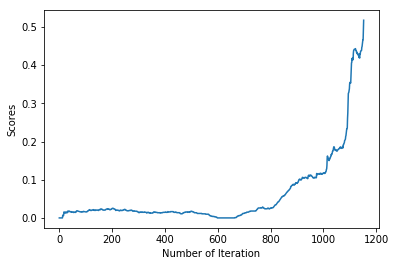

In [12]:
import matplotlib.pyplot as plt
plt.plot(scores_list)
plt.xlabel("Number of Iteration")
plt.ylabel("Scores")